MASH Risk Prediction with NHANES Data (2011-2018)
This notebook builds a machine learning model to predict the risk of Metabolic Dysfunction-Associated Steatotic Hepatopathy (MASH) using publicly available NHANES data.

Strategy:

Target Variable: We will create a proxy for MASH risk using the Fatty Liver Index (FLI). An FLI >= 60 will be classified as 'High Risk'.

Data: We will use data from four National Health and Nutrition Examination Survey (NHAHES) cycles (2011-2012, 2013-2014, 2015-2016, 2017-2018) to create a large, robust dataset. NHAHES is a USA survey by the  Centers for Disease Control and Prevention (CDC).

Features: We will use a core set of demographic, laboratory, examination, and questionnaire variables that are consistently available across all cycles.

Models: We will train and compare a Logistic Regression model (for baseline) and an XGBoost model (for performance).

Interpretation: We will use SHAP to understand the key drivers behind the XGBoost model's predictions.

Cell 1: Import Libraries
First, we import all the necessary libraries for data manipulation, visualization, modeling, and interpretation.

In [7]:
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import shap

# --- Configuration ---
# Suppress warnings for cleaner output and set display options for pandas and seaborn.
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [ ]:
# --- Step 1: Load and Merge Data ---
# To accelerate future runs, the script first checks if a merged CSV file already exists.
# If it does, it loads the data directly from the CSV.
# If not, it processes the raw .xpt files, merges them, and saves the result as a CSV.
merged_data_filename = 'nhanes_merged_2011_2018.csv'

if os.path.exists(merged_data_filename):
    print(f"--- Loading pre-merged data from {merged_data_filename} ---")
    raw_df = pd.read_csv(merged_data_filename, low_memory=False)
else:
    print("--- Step 1: Loading and Merging Data from source files ---")
    data_path = 'nhanes_data/'
    # Define the NHANES cycles to be processed.
    cycles = {
        'G': '2011-2012',
        'H': '2013-2014',
        'I': '2015-2016',
        'J': '2017-2018'
    }
    # Define the prefixes for the data files to be loaded for each cycle.
    file_prefixes = [
        'DEMO', 'BMX', 'BPX', 'TCHOL', 'TRIGLY', 'BIOPRO', 'HDL',
        'GLU', 'GHB', 'CBC', 'DIQ', 'SMQ', 'ALQ', 'PAQ'
    ]
    all_cycle_dfs = []
    # Loop through each cycle, load the corresponding data files, and merge them.
    for letter, year in cycles.items():
        print(f"\n--- Processing Cycle {year} ({letter}) ---")
        cycle_dataframes = {}
        for prefix in file_prefixes:
            file_path = f"{data_path}{prefix}_{letter}.xpt"
            if os.path.exists(file_path):
                print(f"Reading: {file_path}")
                cycle_dataframes[prefix] = pd.read_sas(file_path, format='xport')
            else:
                print(f"File not found, skipping: {file_path}")

        # Merge all dataframes for the current cycle based on the sequence number 'SEQN'.
        if 'DEMO' in cycle_dataframes:
            merged_df = cycle_dataframes['DEMO']
            for prefix, df_to_merge in cycle_dataframes.items():
                if prefix != 'DEMO':
                    merged_df = pd.merge(merged_df, df_to_merge, on='SEQN', how='left')
            all_cycle_dfs.append(merged_df)

    # Concatenate data from all cycles into a single dataframe.
    raw_df = pd.concat(all_cycle_dfs, ignore_index=True)

    # Save the final merged dataframe to a CSV file to speed up subsequent runs.
    print(f"\n--- Saving merged data to {merged_data_filename} ---")
    raw_df.to_csv(merged_data_filename, index=False)

print(f"\nFinal merged shape from all cycles: {raw_df.shape}")

--- Loading pre-merged data from nhanes_merged_2011_2018.csv ---

Final merged shape from all cycles: (39156, 400)


In [9]:
# --- Step 2: Create Target Variable and Select Features ---
print("\n--- Step 2: Creating Target and Features ---")
# The target variable (MASH_RISK) is derived from the Fatty Liver Index (FLI).
# FLI is calculated using Triglycerides, BMI, GGT, and Waist Circumference.
raw_df['log_TRIG'] = np.log(raw_df['LBXTR'])
raw_df['log_GGT'] = np.log(raw_df['LBXSGTSI']) # Using the correct variable name for GGT
fli_numerator = np.exp(
    0.953 * raw_df['log_TRIG'] +
    0.139 * raw_df['BMXBMI'] +
    0.718 * raw_df['log_GGT'] +
    0.053 * raw_df['BMXWAIST'] - 15.745
)
raw_df['FLI'] = (fli_numerator / (1 + fli_numerator)) * 100

# Create a binary target variable 'MASH_RISK'.
# FLI >= 60 is considered high risk (1), and FLI < 30 is low risk (0).
# The "gray area" between 30 and 60 is excluded to create a clearer classification problem.
df_filtered = raw_df[(raw_df['FLI'] < 30) | (raw_df['FLI'] >= 60)].copy()
df_filtered['MASH_RISK'] = np.where(df_filtered['FLI'] >= 60, 1, 0)
print("\nTarget variable distribution:")
print(df_filtered['MASH_RISK'].value_counts(normalize=True))

# Select a consistent set of features available across all NHANES cycles for the model.
# These include demographics, lab results, examination data, and questionnaire responses.
feature_columns = [
    'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'INDFMPIR',
    'LBXGLU', 'LBXGH', 'LBDHDD', 'LBDLDL', 'LBXSAL', 'LBXPLTSI',
    'LBXSATSI', 'LBXSASSI', # AST and ALT
    'BPXSY1', 'BPXDI1',
    'DIQ010', 'SMQ020', 'ALQ130', 'PAQ650'
]
# Create the final modeling dataframe by selecting the target and features, and dropping rows with missing values.
model_df = df_filtered[['MASH_RISK'] + feature_columns].dropna()
print(f"Shape after filtering and dropping NA: {model_df.shape}")


--- Step 2: Creating Target and Features ---

Target variable distribution:
MASH_RISK
0    0.524009
1    0.475991
Name: proportion, dtype: float64
Shape after filtering and dropping NA: (3945, 19)



--- Step 3: Defining Features (X) and Target (y) ---

--- Step 4: Building Preprocessing Pipeline ---

--- Step 5: Training and Evaluating Models ---

--- Training Logistic Regression ---
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       372
           1       0.81      0.82      0.81       417

    accuracy                           0.80       789
   macro avg       0.80      0.80      0.80       789
weighted avg       0.80      0.80      0.80       789

Logistic Regression AUC-ROC: 0.8852

--- Training XGBoost Classifier ---
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       372
           1       0.80      0.82      0.81       417

    accuracy                           0.80       789
   macro avg       0.80      0.80      0.80       789
weighted avg       0.80      0.80      0.80       789

XGBoost 

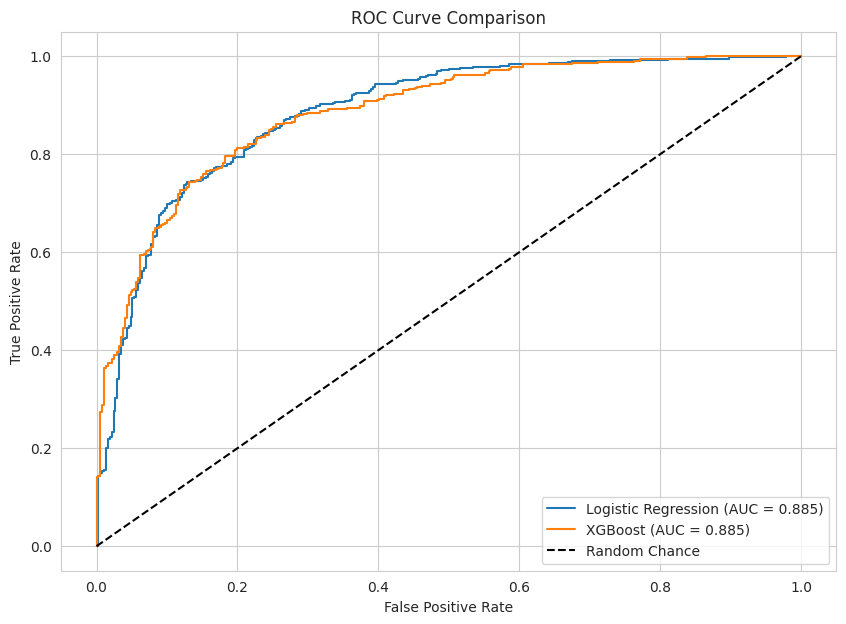

In [10]:
# --- Step 3: Define Features (X) and Target (y) ---
print("\n--- Step 3: Defining Features (X) and Target (y) ---")
X = model_df.drop('MASH_RISK', axis=1)
y = model_df['MASH_RISK']


# --- Step 4: Build Preprocessing Pipeline ---
# A ColumnTransformer is used to apply different preprocessing steps to numerical and categorical features.
print("\n--- Step 4: Building Preprocessing Pipeline ---")
categorical_features = ['RIAGENDR', 'RIDRETH1', 'DIQ010', 'SMQ020']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Numerical features are imputed with the median and then scaled.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categorical features are imputed with the most frequent value and then one-hot encoded.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine the transformers into a single preprocessor object.
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)])


# --- Step 5: Train and Evaluate Models ---
# The data is split into training and testing sets.
print("\n--- Step 5: Training and Evaluating Models ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Logistic Regression ---
# A Logistic Regression model is trained as a baseline for comparison.
# The model is part of a pipeline that includes the preprocessing steps.
print("\n--- Training Logistic Regression ---")
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print(f"Logistic Regression AUC-ROC: {roc_auc_score(y_test, y_prob_lr):.4f}")

# --- XGBoost ---
# An XGBoost classifier is trained for potentially higher performance.
# This model is also integrated into a pipeline with the same preprocessing.
print("\n--- Training XGBoost Classifier ---")
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"XGBoost AUC-ROC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

# --- Plot ROC Curves ---
# The Receiver Operating Characteristic (ROC) curves for both models are plotted to visually compare their performance.
print("\n--- Generating ROC Curve Comparison Plot ---")
plt.figure(figsize=(10, 7))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.3f})')
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


--- Step 6: Interpreting XGBoost Model with SHAP ---
Generating SHAP summary plots...


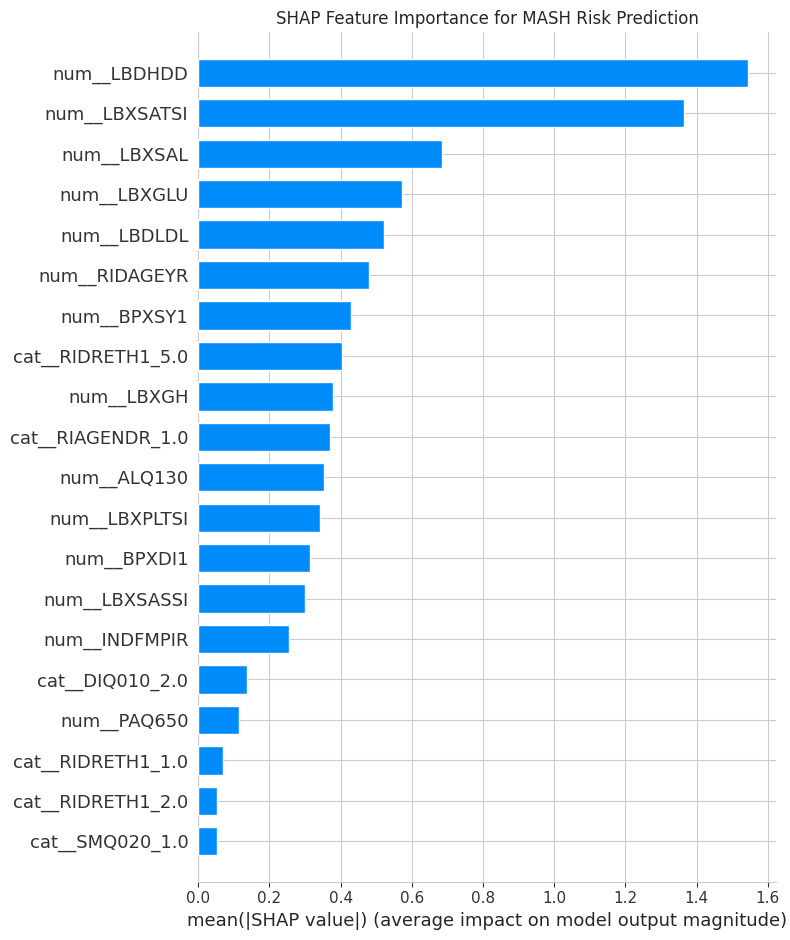

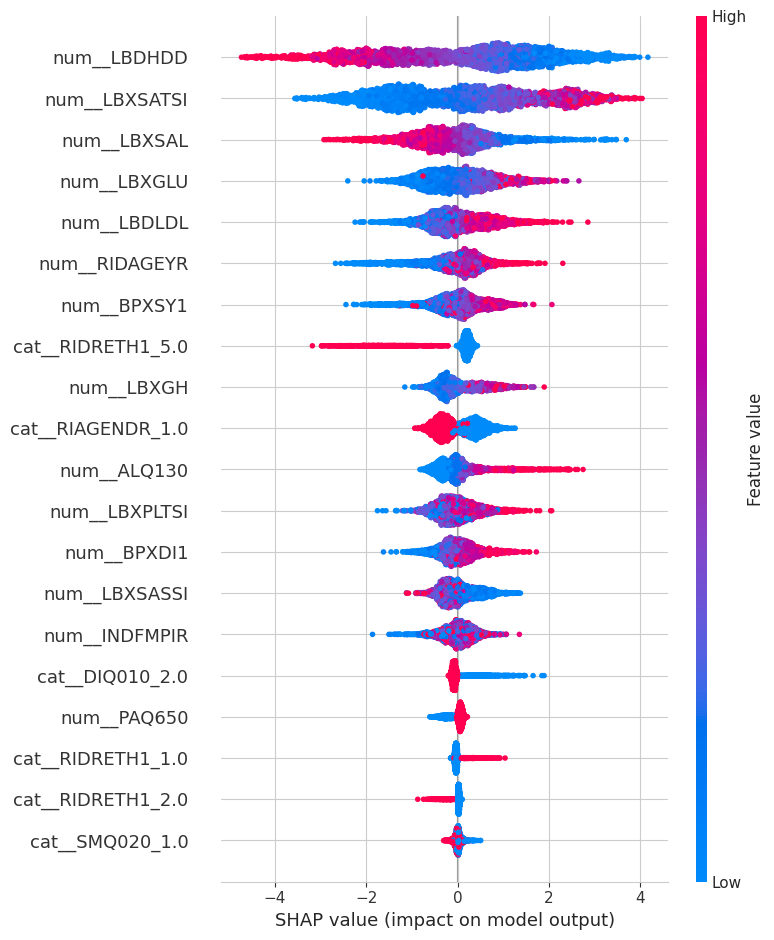


--- Script Execution Complete ---


In [11]:
# --- Step 6: Interpret the XGBoost Model ---
# SHAP (SHapley Additive exPlanations) is used to interpret the predictions of the more complex XGBoost model.
print("\n--- Step 6: Interpreting XGBoost Model with SHAP ---")
# Extract the preprocessor and the trained model from the pipeline.
preprocessor_for_shap = xgb_pipeline.named_steps['preprocessor']
model_for_shap = xgb_pipeline.named_steps['classifier']

# The training data must be transformed before being passed to the SHAP explainer.
X_train_transformed = preprocessor_for_shap.fit_transform(X_train)
# Get the feature names after one-hot encoding for proper labeling in the plots.
feature_names = preprocessor_for_shap.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Create a SHAP explainer and calculate the SHAP values for the training data.
explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer.shap_values(X_train_transformed_df)

# --- Generate SHAP Summary Plots ---
print("Generating SHAP summary plots...")

# The bar plot shows the mean absolute SHAP value for each feature, indicating its overall importance.
plt.title("SHAP Feature Importance for MASH Risk Prediction")
shap.summary_plot(shap_values, X_train_transformed_df, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# The beeswarm plot shows the impact of each feature on the model's output for every observation.
# Each point is an observation, color indicates feature value (high/low), and x-position shows the impact on the prediction.
shap.summary_plot(shap_values, X_train_transformed_df, show=False)
plt.tight_layout()
plt.show()

print("\n--- Script Execution Complete ---")